# Week 02: Web Scraping, Data Processing, and Visualization

This notebook covers the key concepts and practical applications for Week 2, including:
- Web scraping with requests and lxml
- Environment variables management
- HTML and JSON data parsing
- CSV data handling
- Data visualization with matplotlib
- SVG graphics creation

## Learning Objectives
By the end of this notebook, you will be able to:
1. Set up and use environment variables for configuration
2. Scrape data from websites using Python
3. Parse HTML and JSON data effectively
4. Process and visualize time-series data
5. Create programmatic graphics with SVG

## 1. Environment Setup and Dependencies

First, let's load our environment variables and import the required libraries. The `.env` file contains configuration settings that we'll use throughout this notebook.

In [1]:
# Install required packages (run this if packages are not already installed)
!pip install python-dotenv requests lxml matplotlib drawsvg

In [2]:
# Import all required libraries
import os
import datetime
import json
import requests
import dotenv
from lxml import html
import matplotlib.pyplot as plt
import drawsvg as draw

# Import our custom utilities
from scraping_utils import get_url, parse

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Load environment variables from .env file
dotenv.load_dotenv()

# Display the loaded environment variables
print("Loaded environment variables:")
print(f"YEAR: {os.getenv('YEAR')}")
print(f"URL: {os.getenv('URL')}")
print(f"ROW_XPATH: {os.getenv('ROW_XPATH')}")
print(f"COL_XPATH: {os.getenv('COL_XPATH')}")
print(f"MULTICITY_URL: {os.getenv('MULTICITY_URL')}")

Loaded environment variables:
YEAR: 2023
URL: https://www.hko.gov.hk/tide/eCLKtext2023.html
ROW_XPATH: //html/body/table/tbody/tr
COL_XPATH: td
MULTICITY_URL: https://worldweather.wmo.int/en/json/{city_id}_en.xml


## 2. Web Scraping Utilities

Let's examine and demonstrate the utility functions we've created for web scraping. These functions help us fetch web pages and parse different data formats.

In [4]:
# Let's look at our scraping utilities
import inspect

print("get_url function:")
print(inspect.getsource(get_url))
print("\n" + "="*50 + "\n")
print("parse function:")
print(inspect.getsource(parse))

get_url function:
def get_url(url, filename):
    if not os.path.exists(filename):
        
        # set useragent for requests
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        
        # fetch the page if it doesn't exist
        page = requests.get(url, headers=headers)

        # save the page to a file
        with open(filename, 'w', encoding='UTF8') as f:
            f.write(page.text)

        page = page.text

    else:
        # if the page exists, read it from the file
        with open(filename, 'r', encoding='UTF8') as f:
            page = f.read() 
            
    return page



parse function:
def parse(page, mode = 'html'):
    match mode:
        case 'html':
            return html.fromstring(page)
        case 'json':
            return json.loads(page)



In [5]:
# Demonstrate the get_url function with a simple example
# This will either fetch from the web or read from cache

test_url = "https://httpbin.org/json"
test_filename = "test_page.html"

print("Fetching test page...")
page_content = get_url(test_url, test_filename)
print(f"Content length: {len(page_content)} characters")
print(f"First 200 characters: {page_content[:200]}...")

Fetching test page...
Content length: 429 characters
First 200 characters: {
  "slideshow": {
    "author": "Yours Truly", 
    "date": "date of publication", 
    "slides": [
      {
        "title": "Wake up to WonderWidgets!", 
        "type": "all"
      }, 
      {
    ...


In [6]:
# Demonstrate parsing JSON data
json_data = parse(page_content, 'json')
print("Parsed JSON data:")
print(json.dumps(json_data, indent=2))

Parsed JSON data:
{
  "slideshow": {
    "author": "Yours Truly",
    "date": "date of publication",
    "slides": [
      {
        "title": "Wake up to WonderWidgets!",
        "type": "all"
      },
      {
        "items": [
          "Why <em>WonderWidgets</em> are great",
          "Who <em>buys</em> WonderWidgets"
        ],
        "title": "Overview",
        "type": "all"
      }
    ],
    "title": "Sample Slide Show"
  }
}


## 3. HTML Data Extraction and Processing

Now let's work with the actual HTML data that was scraped from the Hong Kong Observatory tide information.

In [7]:
# Load and examine the crawled HTML page
year = int(os.getenv('YEAR', 2024))
filename = os.getenv('FILENAME', "crawled-page-{year}.html").format(year=year)

print(f"Loading HTML file: {filename}")

# Check if the file exists
if os.path.exists(filename):
    with open(filename, 'r', encoding='UTF8') as f:
        html_content = f.read()
    
    print(f"HTML file loaded successfully!")
    print(f"Content length: {len(html_content)} characters")
    print(f"First 500 characters:\n{html_content[:500]}...")
else:
    print(f"HTML file {filename} not found. Let's fetch it from the web.")
    
    # Use environment variable URL
    url = os.getenv('URL').replace('${YEAR}', str(year))
    print(f"Fetching from: {url}")
    
    html_content = get_url(url, filename)
    print(f"Content fetched and saved to {filename}")

Loading HTML file: crawled-page-2023.html
HTML file crawled-page-2023.html not found. Let's fetch it from the web.
Fetching from: https://www.hko.gov.hk/tide/eCLKtext2023.html
Content fetched and saved to crawled-page-2023.html


In [8]:
# Parse the HTML content
tree = parse(html_content, 'html')

# Extract table structure using XPath
rows = tree.xpath(os.getenv('ROW_XPATH'))
print(f"Found {len(rows)} rows in the HTML table")

# Examine the first few rows
print("\nFirst 3 rows structure:")
for i, row in enumerate(rows[:3]):
    columns = row.xpath(os.getenv('COL_XPATH'))
    column_texts = [col.text_content().strip() for col in columns]
    print(f"Row {i+1}: {column_texts}")

Found 377 rows in the HTML table

First 3 rows structure:
Row 1: []
Row 2: ['01', '01', '0531', '1.58', '1127', '1.03', '1844', '2.05', '', '']
Row 3: ['01', '02', '0118', '0.98', '0718', '1.44', '1207', '1.16', '1911', '2.17']


## 4. CSV Data Handling for Tides

Let's process the tide data and create a CSV file, then load and analyze the data.

In [9]:
# Process tide data similar to tides_csv.py
data = []
row_num = 0

print("Processing tide data...")

for row in tree.xpath(os.getenv('ROW_XPATH')):
    columns = row.xpath(os.getenv('COL_XPATH'))
    columns = [column.text_content().strip() for column in columns]
    row_string = " ".join(columns).strip()
    
    # Skip empty rows
    if row_string.strip() == "":
        continue
    
    row_num += 1
    
    # Only process first 5 rows for demonstration
    if row_num <= 5:
        print(f'Row {row_num}: {row_string}')
    
    # Skip header or invalid rows
    if len(columns) < 3 or not columns[0].isdigit():
        continue
    
    try:
        month = int(columns[0])
        day = int(columns[1])
        
        # Process time and value pairs
        for i in range(2, len(columns), 2):
            if i+1 < len(columns) and columns[i] != "" and len(columns[i]) >= 4:
                # Extract time in HHMM format
                time_str = columns[i]
                if len(time_str) >= 4 and time_str.isdigit():
                    hour = int(time_str[:2])
                    minute = int(time_str[2:])
                    
                    dt = datetime.datetime(year, month, day, hour, minute)
                    value = columns[i+1]
                    
                    if value:  # Make sure value is not empty
                        data.append((dt, value))
                        
                        if len(data) <= 10:  # Show first 10 entries
                            print(f'{dt} - {value}')
    except (ValueError, IndexError) as e:
        # Skip problematic rows
        continue

print(f"\nProcessed {len(data)} tide data points")

Processing tide data...
Row 1: 01 01 0531 1.58 1127 1.03 1844 2.05
2023-01-01 05:31:00 - 1.58
2023-01-01 11:27:00 - 1.03
2023-01-01 18:44:00 - 2.05
Row 2: 01 02 0118 0.98 0718 1.44 1207 1.16 1911 2.17
2023-01-02 01:18:00 - 0.98
2023-01-02 07:18:00 - 1.44
2023-01-02 12:07:00 - 1.16
2023-01-02 19:11:00 - 2.17
Row 3: 01 03 0226 0.76 0909 1.41 1243 1.26 1937 2.29
2023-01-03 02:26:00 - 0.76
2023-01-03 09:09:00 - 1.41
2023-01-03 12:43:00 - 1.26
Row 4: 01 04 0318 0.57 1008 1.42 1317 1.31 2004 2.39
Row 5: 01 05 0402 0.42 1048 1.43 1350 1.33 2034 2.47

Processed 1301 tide data points


In [10]:
# Create CSV file
csv_filename = 'tides_processed.csv'

print(f"Creating CSV file: {csv_filename}")

with open(csv_filename, 'w') as f:
    f.write('datetime,tide_level\n')  # Header
    for record in data:
        f.write(f'{record[0].strftime("%Y-%m-%d %H:%M")},{record[1]}\n')

print(f"CSV file created with {len(data)} records")

# Read and display first few lines of the CSV
with open(csv_filename, 'r') as f:
    lines = f.readlines()[:10]
    print("\nFirst 10 lines of CSV:")
    for line in lines:
        print(line.strip())

Creating CSV file: tides_processed.csv
CSV file created with 1301 records

First 10 lines of CSV:
datetime,tide_level
2023-01-01 05:31,1.58
2023-01-01 11:27,1.03
2023-01-01 18:44,2.05
2023-01-02 01:18,0.98
2023-01-02 07:18,1.44
2023-01-02 12:07,1.16
2023-01-02 19:11,2.17
2023-01-03 02:26,0.76
2023-01-03 09:09,1.41


## 5. Multi-City Temperature Data Analysis

Let's demonstrate fetching and processing JSON data from multiple cities' weather information.

In [11]:
# Multi-city temperature analysis (adapted from multi_city_temp.py)
multicity_url = os.getenv('MULTICITY_URL')
cities_data = []

print("Fetching multi-city temperature data...")
print(f"Base URL: {multicity_url}")

# Fetch data for first 3 cities as demonstration
for i in range(1, 4):
    try:
        city_url = multicity_url.format(city_id=i)
        print(f"\nFetching data for city {i}: {city_url}")
        
        page = get_url(city_url, f'city-{i}.json')
        
        # Check if we got valid JSON
        if page.strip().startswith('{'):
            city_data = parse(page, 'json')
            
            if 'city' in city_data:
                city_name = city_data['city']['cityName']
                print(f"City: {city_name}")
                
                if 'climate' in city_data['city'] and 'climateMonth' in city_data['city']['climate']:
                    climate_data = city_data['city']['climate']['climateMonth'][0]
                    print(f"Available climate data keys: {list(climate_data.keys())}")
                    
                    cities_data.append({
                        'id': i,
                        'name': city_name,
                        'data': climate_data
                    })
                else:
                    print("No climate data found")
            else:
                print("No city data found in response")
        else:
            print(f"Invalid JSON response (first 100 chars): {page[:100]}")
            
    except Exception as e:
        print(f"Error fetching data for city {i}: {e}")

print(f"\nSuccessfully fetched data for {len(cities_data)} cities")

Fetching multi-city temperature data...
Base URL: https://worldweather.wmo.int/en/json/{city_id}_en.xml

Fetching data for city 1: https://worldweather.wmo.int/en/json/1_en.xml
City: Hong Kong
Available climate data keys: ['month', 'maxTemp', 'minTemp', 'meanTemp', 'maxTempF', 'minTempF', 'meanTempF', 'raindays', 'rainfall', 'climateFromMemDate']

Fetching data for city 2: https://worldweather.wmo.int/en/json/2_en.xml
City: Lisboa
Available climate data keys: ['month', 'maxTemp', 'minTemp', 'meanTemp', 'maxTempF', 'minTempF', 'meanTempF', 'raindays', 'rainfall', 'climateFromMemDate']

Fetching data for city 3: https://worldweather.wmo.int/en/json/3_en.xml
City: Porto
Available climate data keys: ['month', 'maxTemp', 'minTemp', 'meanTemp', 'maxTempF', 'minTempF', 'meanTempF', 'raindays', 'rainfall', 'climateFromMemDate']

Successfully fetched data for 3 cities


In [12]:
# Display summary of fetched city data
if cities_data:
    print("Summary of fetched city data:")
    for city in cities_data:
        print(f"\nCity {city['id']}: {city['name']}")
        
        # Display some sample climate data if available
        climate = city['data']
        if 'maxTemp' in climate:
            print(f"  Max Temperature: {climate['maxTemp']}")
        if 'minTemp' in climate:
            print(f"  Min Temperature: {climate['minTemp']}")
        if 'rainfall' in climate:
            print(f"  Rainfall: {climate['rainfall']}")
else:
    print("No city data was successfully fetched.")
    print("This might be due to network issues or API changes.")

Summary of fetched city data:

City 1: Hong Kong
  Max Temperature: 18.7
  Min Temperature: 14.6
  Rainfall: 33.2

City 2: Lisboa
  Max Temperature: 14.5
  Min Temperature: 8.2
  Rainfall: 109.6

City 3: Porto
  Max Temperature: 13.5
  Min Temperature: 5.1
  Rainfall: 170.8


## 6. Tides Data Visualization

Now let's create visualizations of our tide data using matplotlib.

In [13]:
# Prepare data for plotting
if data:
    # Convert tide values to float for plotting
    plot_data = []
    for dt, value in data:
        try:
            # Remove any non-numeric characters and convert to float
            numeric_value = float(value.replace('m', '').replace('+', '').strip())
            plot_data.append((dt, numeric_value))
        except ValueError:
            # Skip invalid values
            continue
    
    print(f"Prepared {len(plot_data)} data points for plotting")
    
    if plot_data:
        # Extract dates and values for plotting
        dates = [record[0] for record in plot_data]
        values = [record[1] for record in plot_data]
        
        print(f"Date range: {min(dates)} to {max(dates)}")
        print(f"Value range: {min(values):.2f}m to {max(values):.2f}m")
    else:
        print("No valid numeric data for plotting")
else:
    print("No tide data available for plotting")

Prepared 1301 data points for plotting
Date range: 2023-01-01 05:31:00 to 2023-12-31 23:47:00
Value range: 0.00m to 2.89m


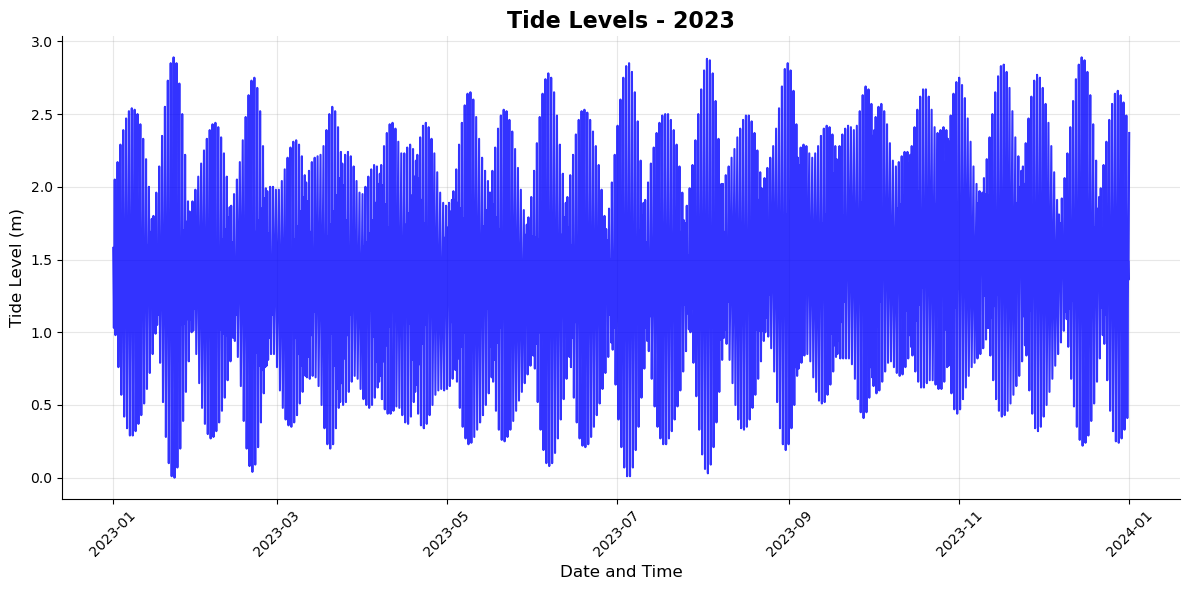


Tide Statistics:
Highest tide: 2.89m
Lowest tide: 0.00m
Average tide: 1.44m
Tide range: 2.89m


In [14]:
# Create tide visualization
if 'plot_data' in locals() and plot_data:
    plt.figure(figsize=(12, 6))
    plt.plot(dates, values, 'b-', linewidth=1.5, alpha=0.8)
    plt.title(f'Tide Levels - {year}', fontsize=16, fontweight='bold')
    plt.xlabel('Date and Time', fontsize=12)
    plt.ylabel('Tide Level (m)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.show()
    
    # Show some statistics
    print(f"\nTide Statistics:")
    print(f"Highest tide: {max(values):.2f}m")
    print(f"Lowest tide: {min(values):.2f}m")
    print(f"Average tide: {sum(values)/len(values):.2f}m")
    print(f"Tide range: {max(values) - min(values):.2f}m")
else:
    print("Creating sample tide visualization...")
    
    # Create sample data for demonstration
    import numpy as np
    
    sample_times = [datetime.datetime(2023, 1, 1) + datetime.timedelta(hours=i) for i in range(48)]
    sample_tides = [2.0 + 1.5 * np.sin(2 * np.pi * i / 12) for i in range(48)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(sample_times, sample_tides, 'b-', linewidth=2)
    plt.title('Sample Tide Data Visualization', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Tide Level (m)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

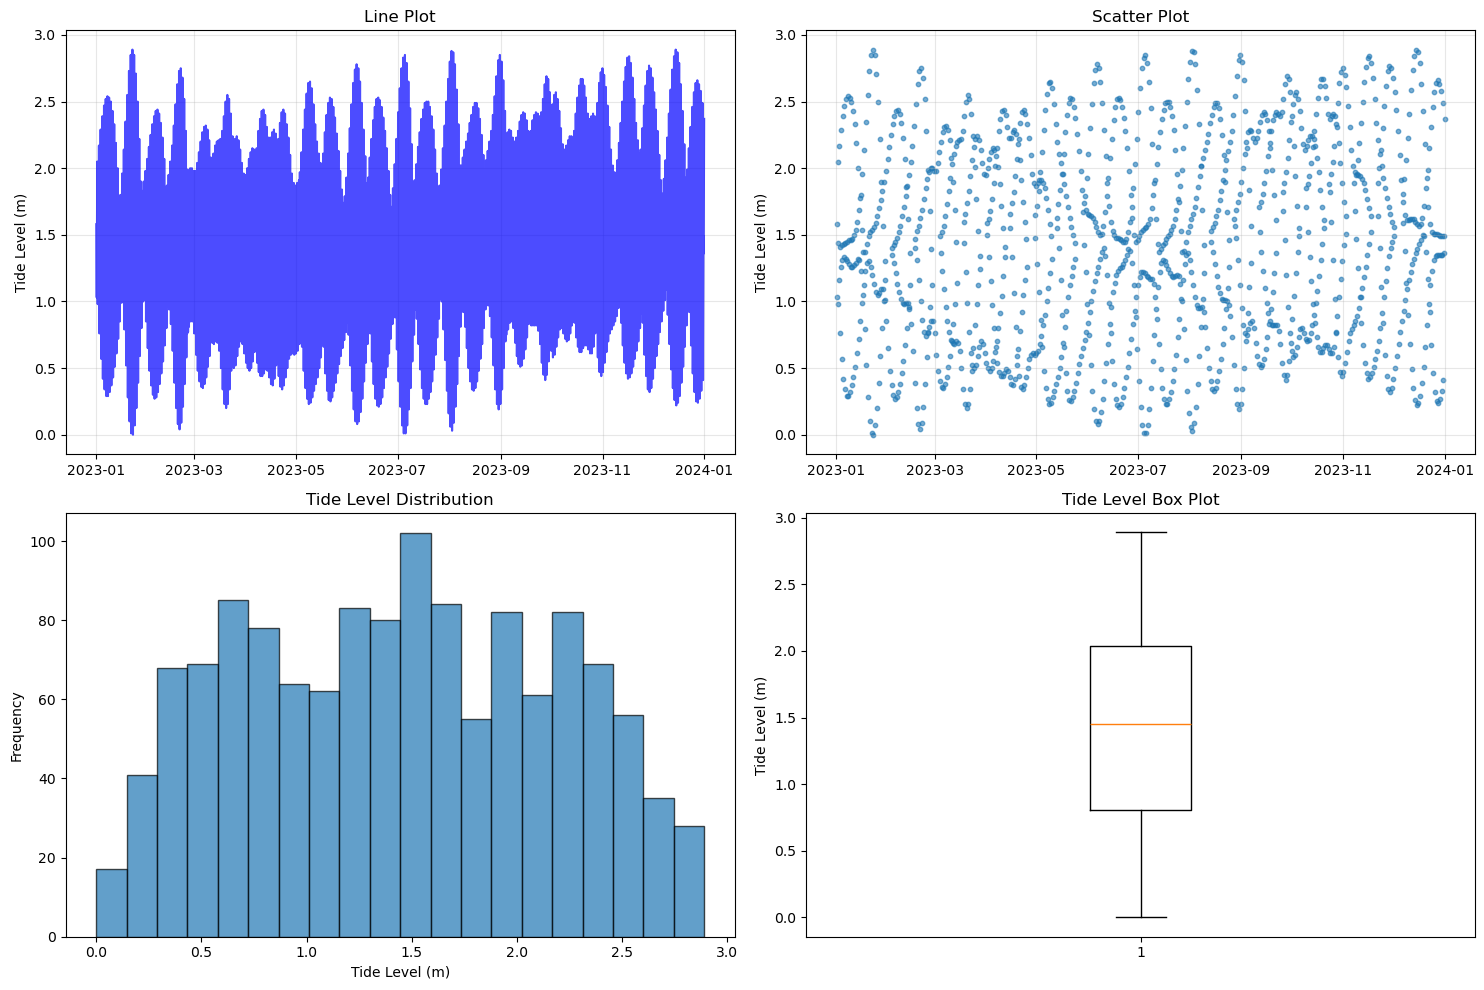

In [15]:
# Create additional visualization styles
if 'plot_data' in locals() and plot_data and len(plot_data) > 10:
    # Create a subplot with multiple visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Line plot
    axes[0, 0].plot(dates, values, 'b-', alpha=0.7)
    axes[0, 0].set_title('Line Plot')
    axes[0, 0].set_ylabel('Tide Level (m)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[0, 1].scatter(dates, values, alpha=0.6, s=10)
    axes[0, 1].set_title('Scatter Plot')
    axes[0, 1].set_ylabel('Tide Level (m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram
    axes[1, 0].hist(values, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Tide Level Distribution')
    axes[1, 0].set_xlabel('Tide Level (m)')
    axes[1, 0].set_ylabel('Frequency')
    
    # Box plot
    axes[1, 1].boxplot(values)
    axes[1, 1].set_title('Tide Level Box Plot')
    axes[1, 1].set_ylabel('Tide Level (m)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for multiple visualizations")

## 7. SVG Drawing and Graphics

Finally, let's explore programmatic graphics creation using SVG. This demonstrates how we can create vector graphics using code.

In [16]:
# Create a basic SVG drawing (from draw_svg.py)
d = draw.Drawing(200, 100, origin='center')

# Draw an irregular polygon
d.append(draw.Lines(-80, 45,
                     70, 49,
                     95, -49,
                    -90, -40,
                    close=False,
            fill='#eeee00',
            stroke='black'))

# Save the SVG
svg_filename = 'irregular-polygon.svg'
d.save_svg(svg_filename)
print(f"SVG saved as: {svg_filename}")

# Display the SVG as text
print("\nSVG content:")
print(d.as_svg())

SVG saved as: irregular-polygon.svg

SVG content:
<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"
     width="200" height="100" viewBox="-100.0 -50.0 200 100">
<defs>
</defs>
<path d="M-80,45 L70,49 L95,-49 L-90,-40" fill="#eeee00" stroke="black" />
</svg>


In [17]:
# Create more complex SVG graphics
# Example 1: Geometric shapes
d2 = draw.Drawing(400, 300, origin='center')

# Add a rectangle
d2.append(draw.Rectangle(-150, -100, 100, 80, fill='lightblue', stroke='navy', stroke_width=2))

# Add a circle
d2.append(draw.Circle(50, 0, 40, fill='red', stroke='darkred', stroke_width=2))

# Add some text
d2.append(draw.Text('Week 02 Graphics', 20, -120, -50, fill='black', font_family='Arial', font_weight='bold'))

# Add lines
d2.append(draw.Line(-100, 50, 100, 50, stroke='green', stroke_width=3))
d2.append(draw.Line(0, -80, 0, 80, stroke='purple', stroke_width=2, stroke_dasharray='5,5'))

# Save and display
geometric_svg = 'geometric-shapes.svg'
d2.save_svg(geometric_svg)
print(f"Geometric shapes SVG saved as: {geometric_svg}")
print(f"SVG dimensions: {d2.width} x {d2.height}")

Geometric shapes SVG saved as: geometric-shapes.svg
SVG dimensions: 400 x 300


In [18]:
# Example 2: Data visualization in SVG
# Create a simple bar chart of tide statistics

d3 = draw.Drawing(500, 300, origin=(0, 0))

# Sample data for visualization
if 'values' in locals() and values:
    # Use actual tide data
    stats = {
        'Max': max(values),
        'Min': abs(min(values)),  # Use absolute value for visualization
        'Avg': sum(values)/len(values)
    }
else:
    # Use sample data
    stats = {'Max': 3.2, 'Min': 0.5, 'Avg': 1.8}

# Draw title
d3.append(draw.Text('Tide Statistics', 24, 250, 30, text_anchor='middle', 
                   fill='black', font_family='Arial', font_weight='bold'))

# Draw bars
bar_width = 60
bar_spacing = 100
start_x = 100
start_y = 250
max_height = 150
scale = max_height / max(stats.values())

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

for i, (label, value) in enumerate(stats.items()):
    x = start_x + i * bar_spacing
    height = value * scale
    
    # Draw bar
    d3.append(draw.Rectangle(x, start_y - height, bar_width, height,
                           fill=colors[i], stroke='black', stroke_width=1))
    
    # Draw label
    d3.append(draw.Text(label, 14, x + bar_width/2, start_y + 20,
                       text_anchor='middle', fill='black'))
    
    # Draw value
    d3.append(draw.Text(f'{value:.1f}m', 12, x + bar_width/2, start_y - height - 10,
                       text_anchor='middle', fill='black', font_weight='bold'))

# Save the chart
chart_svg = 'tide-chart.svg'
d3.save_svg(chart_svg)
print(f"Tide statistics chart saved as: {chart_svg}")
print(f"Chart shows: {stats}")

Tide statistics chart saved as: tide-chart.svg
Chart shows: {'Max': 2.89, 'Min': 0.0, 'Avg': 1.436456571867794}


## Summary and Key Takeaways

In this Week 02 notebook, we have covered:

### 1. **Environment Management**
- Used `.env` files to store configuration
- Loaded environment variables with `python-dotenv`
- Managed sensitive data and configuration separately from code

### 2. **Web Scraping Techniques**
- Created reusable utility functions for web scraping
- Implemented caching to avoid repeated requests
- Handled both HTML and JSON data formats

### 3. **Data Processing**
- Parsed HTML using XPath selectors
- Extracted structured data from web pages
- Converted data to CSV format for further analysis
- Handled date/time data and numeric conversions

### 4. **Data Visualization**
- Created multiple types of plots with matplotlib
- Displayed time-series data effectively
- Generated statistical summaries and distributions

### 5. **Programmatic Graphics**
- Created vector graphics with SVG
- Generated geometric shapes and text
- Built data visualizations using SVG elements

### **Best Practices Demonstrated**
- Error handling for network requests and data parsing
- Code organization with utility functions
- Configuration management with environment variables
- Data validation and cleaning
- Multiple visualization approaches for different insights

### **Next Steps**
- Experiment with different XPath selectors for other websites
- Try scraping different data sources
- Create more complex SVG visualizations
- Combine multiple data sources for richer analysis

In [19]:
# Clean up - list all files created during this session
created_files = []
possible_files = ['test_page.html', 'tides_processed.csv', 'irregular-polygon.svg', 
                 'geometric-shapes.svg', 'tide-chart.svg'] + \
                [f'city-{i}.json' for i in range(1, 10)]

for filename in possible_files:
    if os.path.exists(filename):
        created_files.append(filename)

print("Files created during this session:")
for file in created_files:
    file_size = os.path.getsize(file)
    print(f"  {file} ({file_size} bytes)")

print(f"\nTotal files created: {len(created_files)}")
print("\nWeek 02 notebook completed successfully! 🎉")

Files created during this session:
  test_page.html (450 bytes)
  tides_processed.csv (29944 bytes)
  irregular-polygon.svg (286 bytes)
  geometric-shapes.svg (651 bytes)
  tide-chart.svg (1248 bytes)
  city-1.json (4776 bytes)
  city-2.json (3646 bytes)
  city-3.json (3672 bytes)

Total files created: 8

Week 02 notebook completed successfully! 🎉
